In [80]:
# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import chi2

# Machine Learning - preprocessing and model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Machine Learning - models
from sklearn.linear_model import LogisticRegression

# Machine Learning - metrics
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
#from imblearn.metrics import geometric_mean_score  # Requires imbalanced-learn package

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
from numpy.random import seed

In [81]:
df = pd.read_csv('googleplaystore.csv')

In [82]:
df = df[df['Installs'] != 'free']

In [83]:
df['Reviews'] = pd.to_numeric(df['Reviews'],errors = 'coerce')

In [84]:
def install_map(value):
    # Convert all entries to strings first
    str_value = str(value)
    # Remove '+' and commas, then convert to integer if possible
    num_value = str_value.replace('+', '').replace(',', '')
    try:
        num_value = int(num_value)
        return 1 if num_value >= 1000000 else 0
    except ValueError:
        if 'Free' in str_value:  # Handle 'Free' as a special case
            return 0
        return None  # Handle other non-numeric entries


df['InstallCategory'] = df['Installs'].map(install_map)

In [85]:
df['Price'] = df['Price'].str.replace('$', '', regex=False)

In [86]:
df['Price'] = pd.to_numeric(df['Price'],errors = 'coerce')

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   App              10841 non-null  object 
 1   Category         10841 non-null  object 
 2   Rating           9367 non-null   float64
 3   Reviews          10840 non-null  float64
 4   Size             10841 non-null  object 
 5   Installs         10841 non-null  object 
 6   Type             10840 non-null  object 
 7   Price            10840 non-null  float64
 8   Content Rating   10840 non-null  object 
 9   Genres           10841 non-null  object 
 10  Last Updated     10841 non-null  object 
 11  Current Ver      10833 non-null  object 
 12  Android Ver      10838 non-null  object 
 13  InstallCategory  10841 non-null  int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 1.2+ MB


In [88]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,InstallCategory
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19M,"10,000+",Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,0
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,"500,000+",Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7M,"5,000,000+",Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,1
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25M,"50,000,000+",Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,1
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8M,"100,000+",Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,0


In [89]:
df.InstallCategory.value_counts()

InstallCategory
0    6430
1    4411
Name: count, dtype: int64

In [90]:
df.isnull().sum()

App                   0
Category              0
Rating             1474
Reviews               1
Size                  0
Installs              0
Type                  1
Price                 1
Content Rating        1
Genres                0
Last Updated          0
Current Ver           8
Android Ver           3
InstallCategory       0
dtype: int64

In [91]:
df = df.dropna(subset=['Rating'])
df = df.dropna(subset=['Reviews'])
df = df.dropna(subset=['Price'])

In [92]:
df.isnull().sum()

App                0
Category           0
Rating             0
Reviews            0
Size               0
Installs           0
Type               0
Price              0
Content Rating     0
Genres             0
Last Updated       0
Current Ver        4
Android Ver        2
InstallCategory    0
dtype: int64

In [93]:
dfclean = df[['Rating', 'Reviews','Price', 'InstallCategory']]

In [94]:
dfclean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9366 entries, 0 to 10840
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rating           9366 non-null   float64
 1   Reviews          9366 non-null   float64
 2   Price            9366 non-null   float64
 3   InstallCategory  9366 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 365.9 KB


In [95]:
dfclean.InstallCategory.value_counts()

InstallCategory
0    4957
1    4409
Name: count, dtype: int64

<Axes: ylabel='InstallCategory'>

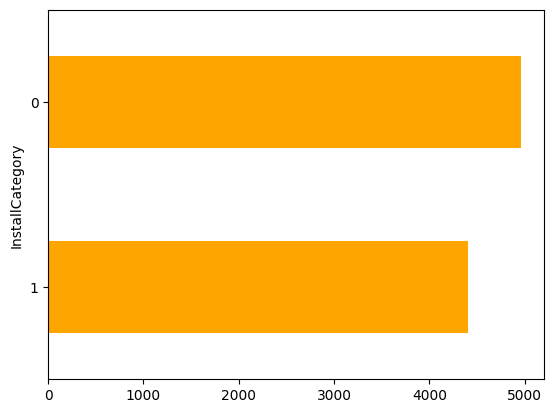

In [96]:
dfclean.InstallCategory.value_counts().sort_values().plot(kind = 'barh',color='orange')


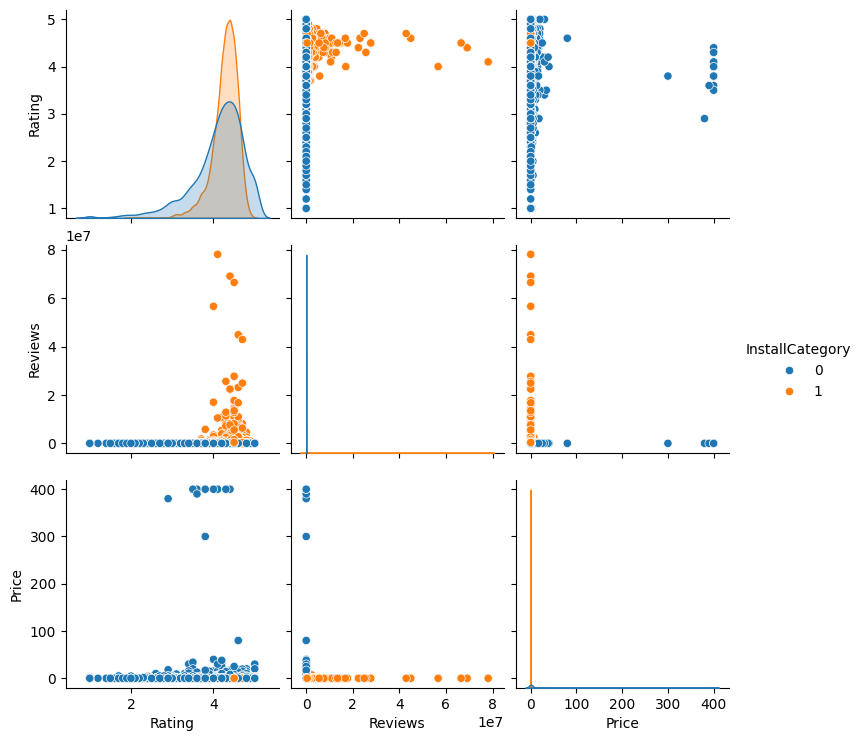

In [97]:
sns.pairplot(dfclean[['InstallCategory', 'Rating', 'Reviews', 'Price']], hue='InstallCategory')

In [98]:
seed(42)  # You can choose any number as a seed value.



default_data = dfclean

# Splitting the dataset into features and target variable
X = default_data.drop('InstallCategory', axis=1)
y = default_data['InstallCategory']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Defining preprocessing for numerical and categorical columns
numeric_features = ['Rating', 'Reviews','Price']


numeric_transformer = StandardScaler()

# Creating the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

# Creating the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Setting up the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__solver': ['lbfgs', 'liblinear']
}

# Setting up stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Fitting the grid search to the training data
grid_search.fit(X_train, y_train)

# Extracting the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluating the model on the test data
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# Calculating metrics
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
error_rate_train = 1 - accuracy_train
error_rate_test = 1 - accuracy_test
f1_score_test = f1_score(y_test, y_pred_test, pos_label=1)  # Assuming 'Yes' is the positive class

# Confusion Matrix for Test Data
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print metrics
print(f"Train Accuracy: {accuracy_train*100:.2f}%")
print(f"Test Accuracy: {accuracy_test*100:.2f}%")
print(f"Train Error Rate: {error_rate_train*100:.2f}%")
print(f"Test Error Rate: {error_rate_test*100:.2f}%")
print(f"Test F1 Score: {f1_score_test:.2f}")

# Detailed classification report
print(classification_report(y_test, y_pred_test))


Train Accuracy: 93.62%
Test Accuracy: 94.56%
Train Error Rate: 6.38%
Test Error Rate: 5.44%
Test F1 Score: 0.94
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       992
           1       0.97      0.91      0.94       882

    accuracy                           0.95      1874
   macro avg       0.95      0.94      0.95      1874
weighted avg       0.95      0.95      0.95      1874



In [99]:
conf_matrix

array([[969,  23],
       [ 79, 803]])